# 1. Tại sao cần quantization

Khi tôi viết bài này thì quantization đã khá phổ biến trong Deep Learning. Đây là một khái niệm không còn mới, nhưng lại rất quan trọng. Vậy nó quan trọng như thế nào và vì sao chúng ta lại cần quantization ?

Các mô hình deep learning ngày càng đạt độ chính xác cao hơn qua thời gian. Không khó để bạn tìm thấy những mô hình đạt độ chính xác SOTA trên bộ dữ liệu ImageNet. Nếu không tin bạn có thể theo dõi độ chính xác qua thời gian trên bảng leader board của [Imagenet classification](https://paperswithcode.com/sota/image-classification-on-imagenet).

Nhưng hầu hết những mô hình có độ chính xác cao lại không có khả năng deploy trên các thiết bị IoT và mobile có phần cứng rất yếu vì nó quá lớn để triển khai.

Quantization là một kỹ thuật giúp bạn **giảm nhẹ kích thước** các mô hình deep learning nhiều lần, đồng thời **giảm độ trễ  (latency)** và **tăng tốc độ inference**. Cùng tìm hiểu về kỹ thuật tuyệt vời này qua bài viết hôm nay.



## 1.1. Khái niệm về quantization

Có nhiều định nghĩa khác nhau về quantization. Xin được trích dẫn khái niệm từ [wikipedia](https://en.wikipedia.org/wiki/Quantization_(signal_processing)):

`
Quantization, in mathematics and digital signal processing, is the process of mapping input values from a large set (often a continuous set) to output values in a (countable) smaller set, often with a finite number of elements. Rounding and truncation are typical examples of quantization processes. Quantization is involved to some degree in nearly all digital signal processing, as the process of representing a signal in digital form ordinarily involves rounding. Quantization also forms the core of essentially all lossy compression algorithms.
`

Như vậy quantization trong toán học và xử lý tín hiệu số là quá trình map các giá trị đầu vào từ một tập số lớn (thường là liên tục) sang các giá trị output là một tập nhỏ hơn có thể đếm được, hữu hạn các phần tử.

**Ví dụ về quantization**

Bạn có thể hình dung dễ dàng khái niệm trên thông qua ví dụ sau đây:

Giả sử  một hàm $f(x) = sin(x)$ là một hàm liên tục trong khoảng $[-\pi, \pi]$. Ta có thể tìm được một tập hợp $S = \{\frac{i \pi}{100}\} \forall, i \in [-100, 100]$ là một tập hữu hạn rời rạc các điểm cách đều nhau một khoảng là $\frac{\pi}{100}$ sao cho tập các điểm $(x, y)$ có miền xác định trên tập $S$ có thể biểu diễn một cách gần đúng mọi điểm $(x, y)$ trên miền liên tục $[-\pi, \pi]$.





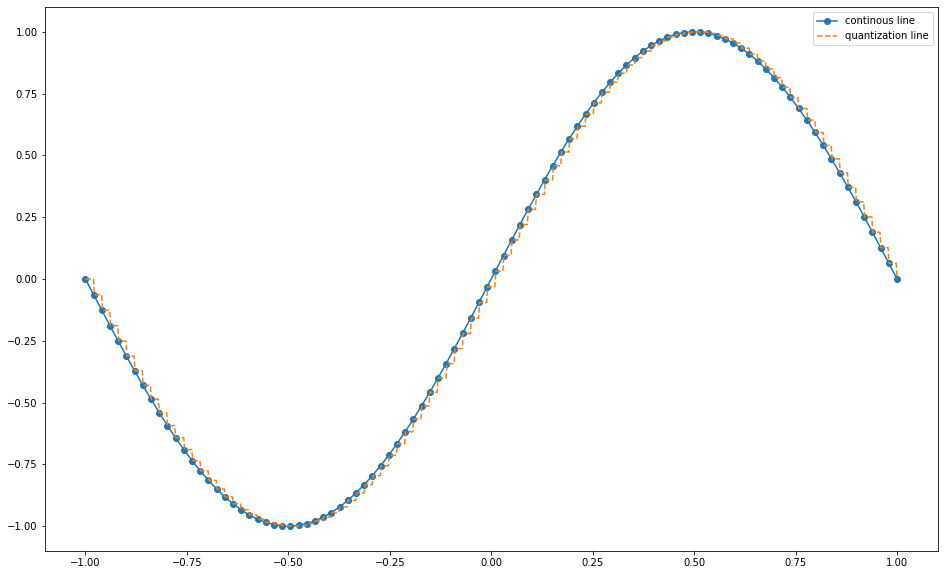

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

x = np.linspace(-1, 1, num=100)
xnew = np.linspace(-1, 1, num=1000, endpoint=True)
y = np.sin(x*np.pi)
f = interpolate.interp1d(x, y, kind='previous')
intpol = f(xnew)
plt.figure(figsize=(16, 10))
plt.plot(x, y, marker='o', label = 'continous line')
plt.plot(xnew, intpol, '--', label = 'quantization line')
plt.legend()
plt.show()


**Hình 1:** Biểu diễn của hàm $sin(x)$ và giá trị quantization của nó trên khoảng $[-\pi, \pi].$

Trong quá trình inference model thì các xử lý được tính toán chủ yếu trên kiểu dữ liệu float32. Đơn vị khoảng (interval unit) của float32 rất nhỏ và dường như là liên tục. Do đó nó có thể biểu diễn mọi giá trị. Trong khi int8 và float16 là những tập hợp có kích thước nhỏ hơn và có đơn vị khoảng lớn hơn rất nhiều so với float32. Việc chuyển đổi định dạng từ float32 sang float16 hoặc int8 có thể coi là quantization theo định nghĩa nêu trên.

float32 sẽ có kích thước nghi nhớ lớn hơn so với các kiểu lưu trữ khác như int8, float16. Để lưu trữ float32 thì chúng ta cần 32 bits. Các bits này nhận một trong hai gía trị 0, 1 để máy có thể đọc được. Quantization hiểu đơn giản hơn là kỹ thuật chuyển đổi định dạng của dữ liệu từ những kiểu dữ liệu có độ chính xác cao sang những kiểu dữ liệu có độ chính xác thấp hơn, qua đó làm giảm memory khi lưu trữ. Do đó làm tăng tốc độ inference là giảm latency khi load model. Tất nhiên là khi bạn làm giảm độ chính xác xuống thì thường accuracy của mô hình sẽ giảm một chút (không quá nhiều) so với mô hình gốc.

Bạn đọc đã hiểu về quantization rồi chứ ? Đơn giản phải không nào ?


## 1.2. Quantization giảm kích thước bao nhiêu lần ?

### 1.2.1. Biểu diễn nhị phân

Trên máy tính, mọi giá trị đều được biểủ diễn dưới dạng nhị phân gồm các bit $\{0, 1\}$.

**Cách convert một số nguyên từ hệ thập phân sang hệ nhị phân**

Chúng ta có thể biểu diễn dễ dàng một số nguyên dưới dạng nhị phân bằng cách khai triển thành tổng các lũy thừa của 2.

$$x = \sum_{i=1}^{n} d_i(0, 1) \times 2^{i}$$

Trong đó $d_i(0, 1) \in \{ 0, 1 \}$. Biểu diễn nhị phân của $x$ sẽ là chuỗi $d_n d_{n-1} \dots d_0$ mà mỗi vị trí $d_i$ nhận 2 giá trị $\{0, 1\}$. Ở cấp 2 chắc các bạn đã từng làm bài toán biến đổi số thập phân sang hệ nhị phân. Bạn còn nhớ chúng ta sẽ thực hiện liên tiếp các phép chia liên hoàn cho 2 cho đến khi không chia được nữa chứ ? Quá trình này lặp lại cho đến khi kết quả thu được sau cùng là 0. Khi đó phần dư ở các bước chia sẽ được lưu lại và cuối cùng nghịch đảo thứ tự của chuỗi phần dư ta thu được biểu diễn nhị phân của số thập phân. Cùng xem hình bên dưới.

![](https://i.imgur.com/MaNZGw4.jpeg)

**Hình 2:** Phương pháp tìm biểu diễn nhị phân của 19 thông qua phép chia liên hoàn cho 2. Kết quả thu được là `10011`.

Chứng minh công thức này không khó, mình xin dành cho bạn đọc như một bài tập bổ sung.

Dựa trên ý tưởng trên, chúng ta có thể code hàm biến đổi số nguyên dương sang nhị phân một cách khá dễ dàng:

In [ ]:
import numpy as np

def _binary_integer(integer):
  exps = []
  odds = []
  # Hàm lấy phần nguyên và phần dư khi chia cho 2
  def _whole_odd(integer):
    # phần nguyên là whole, phần dư là odd.
    whole = integer // 2;
    odd = integer % 2;
    return whole, odd
  
  (whole, odd) = _whole_odd(integer)
  odds.append(odd)
  while (whole > 0): # Khi phần nguyên vẫn lớn hơn 0 thì còn tiếp tục chia.
    (whole, odd) = _whole_odd(whole)
    # Lưu lại phần dư sau mỗi lượt chia
    odds.append(odd)
  # Revert chuỗi số dư để thu được list nhị phân
  odds = np.array(odds)[::-1]
  return odds
    
_binary_integer(19)

array([1, 0, 0, 1, 1])

Như vậy bạn đã nắm được ý tưởng biến đổi một số nguyên sang hệ nhị phân rồi chứ ? Tiếp theo chúng ta cùng phân tích biểu diễn của một số nguyên đối với định dạng float 32.

Giả sử số đó là `1997`. Khi biểu diễn dưới dạng float 32 thì chúng ta sẽ đưa thêm phần thập phân vào sau nó.

In [ ]:
print("Integer Part: ", "".join([str(i) for i in _binary_integer(1993)]))
print("Total Bits: ", len(_binary_integer(1993)))

Integer Part:  11111001001
Total Bits:  11


Phần nguyên chiếm 11 bits, như vậy 21 bits còn lại sẽ là các chữ số 0 ở phần thập phân và dấu phảy. Tuy nhiên khi chuyển sang định dạng float 16 thì ta chỉ cần 16 bits để lưu cùng số nguyên ở trên, trong đó 11 bits cho phần nguyên và 5 bits còn lại cho phần thập phân và dấu phảy. Số bits sử dụng sẽ giảm một nửa giúp cho mô hình giảm một nửa bộ nhớ lưu trữ.


## 1.3. Các dạng quantization

Bên dưới là bảng mức độ giảm kích thước (về bộ nhớ, số lượng tham số mô hình không đổi) khi thực hiện quantization theo các kiểu dữ liệu khác nhau.

![](https://imgur.com/BkDM4I0.png)

Source: [Post training quantization - tensorflow](https://www.tensorflow.org/lite/performance/post_training_quantization)


Trong bảng trên là 3 kiểu quantization cơ bản với các tính chất khác nhau.

* **Dynamic range quantization**: Đây là kiểu quantization mặc định của tflite. Ý tưởng chính là dựa trên khoảng biến thiên của dữ liệu trên một batch để ước lượng các giá trị quantization. Kiểu quantization này giúp giảm 4 lần kích thước bộ nhớ, tăng tốc độ 2-3 lần trên CPU.

* **Full Integer quantization**: Toàn bộ các hệ số sẽ được chuyển về kiểu số nguyên. Kích thước bộ nhớ giảm 4 lần, tăng 3 lần tốc độ trên CPU, TPU, Microcontrollers.

* **Float16 quantization**: Tất nhiên là sẽ được chuyển về kiểu số nguyên và kích thước giảm 2 lần (từ 32 bits về 16 bits). Giúp tăng tốc tính toán trên GPU.

Hiện nay hầu hết các framework deep learning đều hỗ trợ quantization. Trong khuôn khổ của blog này mình chỉ xin giới thiệu quantization trên framework tensorflow.

# 2. Quantization trên tensorflow

Về Quantization trên tensorflow thì đã có hướng dẫn khá chi tiết cho 3 kiểu ở trên. Các bạn có thể xem tại [Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization).

Trong bài viết này thì mình chỉ tổng hợp lại các ý chính bao gồm: 

* Cách convert model trên tflite.
* Thực hiện quantization.
* Kiểm tra độ chính xác của mô hình sau khi quantization.

Trên tensorflow chúng ta thường quantization mô hình trên tensorflow lite trước khi deploy trên các thiết bị di động. Nếu bạn chưa biết về tensorflow lite thì đây là một định dạng thuộc kiểu FlatBuffer, một cross platform hỗ trợ nhiều ngôn ngữ khác nhau như `C++, C#, C, Go, Java, Kotlin, JavaScript, Lobster, Lua, TypeScript, PHP, Python, Rust, Swift`. FlatBuffer cho phép serialization data nhanh hơn so với các kiểu dữ liệu khác như Protocol Buffer vì nó bỏ qua quá trình data parsing. Do đó quá trình load model sẽ nhanh hơn đáng kể.

Tiếp theo chúng ta sẽ thực hành Quantization model trên định dạng `tflite`.





## 2.1. Convert một model tflite

Tensorflow cung cấp một module là `tf.lite.TFLiteConverter` để convert dữ liệu từ các định dạng như `.pb, .h5` sang `.tflite`.

Để đơn giản thì mình sẽ không huấn luyện model từ đầu mà load một pretrain model từ tensorflow hub. [Tensorflow hub](https://www.tensorflow.org/hub) là một nơi khá tuyệt vời chia sẻ opensource chia sẻ các mô hình pretrain trên tensorflow. Từ hình ảnh, văn bản cho tới tiếng nói. Bạn có thể tìm được rất nhiều các pretrain model tại đây. Đồng thời nếu muốn chia sẻ weight từ các mô hình của mình, bạn cũng có thể trở thành một [Tensorhub publisher](https://www.tensorflow.org/hub/publish).

Để load một pretrain layer trên tensorflow hub thực hiện như sau:

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

mobilenet_v2 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
  hub.KerasLayer("https://tfhub.dev/tensorflow/tfgan/eval/mnist/logits/1"),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
mobilenet_v2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              4363712   
_________________________________________________________________
dense (Dense)                (None, 10)                17930     
Total params: 4,381,642
Trainable params: 17,930
Non-trainable params: 4,363,712
_________________________________________________________________


Huấn luyện lại model trên tập dữ liệu mnist

In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0


mobilenet_v2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
mobilenet_v2.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

Epoch 1/5
1875/1875 [==============================] - 58s 31ms/step - loss: 1.7381 - accuracy: 0.7561 - val_loss: 1.5047 - val_accuracy: 0.9824
Epoch 2/5
1875/1875 [==============================] - 58s 31ms/step - loss: 1.4927 - accuracy: 0.9857 - val_loss: 1.4856 - val_accuracy: 0.9866
Epoch 3/5
1875/1875 [==============================] - 57s 31ms/step - loss: 1.4820 - accuracy: 0.9889 - val_loss: 1.4804 - val_accuracy: 0.9878
Epoch 4/5
1875/1875 [==============================] - 57s 31ms/step - loss: 1.4779 - accuracy: 0.9904 - val_loss: 1.4782 - val_accuracy: 0.9885
Epoch 5/5
1875/1875 [==============================] - 57s 31ms/step - loss: 1.4758 - accuracy: 0.9910 - val_loss: 1.4765 - val_accuracy: 0.9887


Model của chúng ta được khởi tạo từ keras nên nó có định dạng `h5`. Chúng ta có thể convert model sang `.tflite`.

In [ ]:
import pathlib

converter = tf.lite.TFLiteConverter.from_keras_model(mobilenet_v2)
mobilenetv2_tflite = pathlib.Path("/tmp/mobilenet_v2.tflite")
mobilenetv2_tflite.write_bytes(converter.convert())
!ls -lh /tmp

INFO:tensorflow:Assets written to: /tmp/tmpua53ldhf/assets


INFO:tensorflow:Assets written to: /tmp/tmpua53ldhf/assets


total 13M
-rw-r--r-- 1 root root  13M Nov 21 14:24 mobilenet_v2.tflite
drwxr-xr-x 2 root root 4.0K Nov 21 13:57 __pycache__
-rw------- 1 root root  461 Nov 21 13:36 tmp2gra8nm1.py
-rw------- 1 root root 5.7K Nov 21 13:35 tmp84s7w721.py
-rw------- 1 root root 1.1K Nov 21 13:36 tmpeiaoz8w9.py
-rw------- 1 root root 2.6K Nov 21 13:35 tmpmqhsez24.py
-rw------- 1 root root  931 Nov 21 13:57 tmpndkkbpy7.py
-rw------- 1 root root 3.5K Nov 21 13:35 tmpx7jgybfh.py
-rw------- 1 root root  931 Nov 21 13:56 tmpzeqpyi47.py


Như vậy ở định dạng tflite chúng ta có mô hình `mobilenet_v2.tflite` có kích thước là 13 Mb.


## 2.2. Quantization model

Để quantization được các layer input, output và layer trung gian thì chúng ta phải thông qua RepresentativeDataset, RepresentativeDataset là một generator function có kích thước đủ lớn, có tác dụng ước lượng khoảng biến thiên cho toàn bộ các tham số của mô hình.

In [ ]:
def _quantization_int8(model_path):
  def representative_data_gen():
    # prepare batch with batch_size = 100
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
      input_value = tf.reshape(input_value, (1, 28, 28, 1))
      yield [input_value]
  # Declare optimizations model
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  # representative dataset
  converter.representative_dataset = representative_data_gen
  # Declare target specification data type
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  # Define input and output data type
  converter.inference_input_type = tf.uint8
  converter.inference_output_type = tf.uint8
  tflite_model_quant = converter.convert()
  mobilenetv2_quant_tflite = pathlib.Path(model_path)
  mobilenetv2_quant_tflite.write_bytes(tflite_model_quant)
  return tflite_model_quant

tflite_model_quant = _quantization_int8("/tmp/mobilenet_v2_quant.tflite")

INFO:tensorflow:Assets written to: /tmp/tmp7_vyq_ud/assets


INFO:tensorflow:Assets written to: /tmp/tmp7_vyq_ud/assets


Trong hàm `_quantization_int8` Chúng ta phải khai báo các tham số cho converter. Trong đó bao gồm các nội dung:

* optimizations: Phương pháp tối ưu được sử dụng để tính toán quantization sao cho sai số là nhỏ nhất so với định dạng gốc.
* representative_dataset: Generator trả ra một batch input $\mathbf{X}$ cho mô hình. Có kích thước đủ lớn để tính toán dynamic range cho các tham số của mô hình.
* target_spec: Định dạng tính toán của các operation trong mạng deep learning.
* inference_input_type: Định dạng input. 
* inference_output_type: Định dạng output.

Định dạng input, output và target_spec phải chung một kiểu với định dạng dữ liệu quantization.

Trước khi quantization thì định dạng của input và output là float32, sau quantization thì chúng được chuyển về int8.



In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Kích thước mô hình sau khi chuyển đổi

In [ ]:
!ls -lh /tmp

total 16M
-rw-r--r-- 1 root root 3.2M Nov 21 14:45 mobilenet_v2_quant.tflite
-rw-r--r-- 1 root root  13M Nov 21 14:24 mobilenet_v2.tflite
drwxr-xr-x 2 root root 4.0K Nov 21 13:57 __pycache__
-rw------- 1 root root  461 Nov 21 13:36 tmp2gra8nm1.py
-rw------- 1 root root 5.7K Nov 21 13:35 tmp84s7w721.py
-rw------- 1 root root 1.1K Nov 21 13:36 tmpeiaoz8w9.py
-rw------- 1 root root 2.6K Nov 21 13:35 tmpmqhsez24.py
-rw------- 1 root root  931 Nov 21 13:57 tmpndkkbpy7.py
-rw------- 1 root root 3.5K Nov 21 13:35 tmpx7jgybfh.py
-rw------- 1 root root  931 Nov 21 13:56 tmpzeqpyi47.py


Chúng ta có thể thấy quantization đã làm giảm kích thước file tflite so với ban đầu gấp 4 lần. Bạn đọc cũng có thể tự kiểm tra tốc độ inference của mô hình sau khi quantization.

## 2.3. Độ chính xác của mô hình quantization

Sau khi thực hiện quantization chúng ta luôn phải kiểm tra lại độ chính xác trên một tập validation độc lập. Quá trình này đảm bảo mô hình sau quantization có chất lượng không quá giảm so với mô hình gốc.

**Kiểm tra độ chính xác mô hình trên tập validation**

In [ ]:
def _run_tflite_model(model_file, test_images, test_image_indices):
  # Khởi tạo model tf.lite
  interpreter = tf.lite.Interpreter(model_path=str(model_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Dự báo
  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = tf.reshape(test_images[test_image_index], (28, 28, 1))
    test_label = test_labels[test_image_index]

    # Kiểm tra xem input đã được quantized, sau đó rescale input data sang uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    predictions[i] = output.argmax()
  return predictions

# Helper function to evaluate a TFLite model on all images
def _evaluate_model(model_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = _run_tflite_model(model_file, test_images, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))
  
_evaluate_model("/tmp/mobilenet_v2_quant.tflite", model_type="unit8"")

Float model accuracy is 98.8700% (Number of test samples=10000)


Ta thấy sau khi quantization thì độ chính xác của mô hình giảm khoảng 0.5%. Đây là một mức giảm không đáng kể so với lợi ích đạt được từ việc giảm kích thước mô hình và tốc độ inference.

### 2.3.1. Convert model by commandline

Ngoài sử dụng `tf.lite.TFLiteConverter` để convert model thì chúng ta có thể convert trên commandline. Để tránh các lỗi phát sinh thì kinh nghiệm của mình là các bạn nên convert từ save mode của mô hình (save model là định dạng lưu trữ được cả graph của mô hình và tham số trong các checkpoint, do đó hạn chế được lỗi so với phương pháp chỉ lưu tham số).

**Lưu mô hình dưới dạng savemode**

In [ ]:
mobilenet_v2.save("/tmp/mobilenet_v2")
!ls /tmp/mobilenet_v2/

INFO:tensorflow:Assets written to: /tmp/mobilenet_v2/assets


INFO:tensorflow:Assets written to: /tmp/mobilenet_v2/assets


assets	saved_model.pb	variables


In [ ]:
!ls /tmp/mobilenet_v2/

assets	saved_model.pb	variables


In [ ]:
!tflite_convert \
  --saved_model_dir=/tmp/mobilenet_v2 \
  --output_file=/tmp/mobilenet_v2_quant_cmd.tflite

!ls -lh /tmp

2020-11-21 15:37:17.750486: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-21 15:37:17.759721: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-11-21 15:37:17.759803: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (59fb3b9908d3): /proc/driver/nvidia/version does not exist
2020-11-21 15:37:17.786543: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2020-11-21 15:37:17.786937: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556e6502ebc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-21 15:37:17.786990: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-11-21 15:37:18.172092: I tensorflow/core/grappler/de

### 2.3.2. Quantization trên pytorch

Trên pytorch cũng hỗ trợ ba định dạng quantization tương tự như tensorflow. Về hướng dẫn quantization cho các model trên pytorch thì các bạn có thể tham khảo tại hướng dẫn [pytorch - quantization](https://pytorch.org/docs/stable/quantization.html), khá đầy đủ và chi tiết. Nếu có dịp mình sẽ làm một bài hướng dẫn khác trên pytorch.

## 3. Kết luận

Như vậy qua bài viết này mình đã hướng dẫn tới các bạn ý tưởng chính của quantization. Các thức để tiến hành quantization trên tensorflow lite và kiểm tra độ chính xác của mô hình sau quantization.

Đây là một trong những phương pháp được sử dụng phổ biến trong quá trình xây dựng và triển khai các model deep learning trên những thiết bị có cấu hình yếu. Bên cạnh phương pháp quantization thì còn có nhiều phương pháp khác như `pruning, weight-sharing, Knowledge Distillation, binary network` cũng giúp cho mô hình có kích thước nhẹ hơn và tăng tốc độ inference mà mình sẽ tiếp tục giới thiệu tới các bạn trong những bài sắp tới.

Cảm ơn các bạn đã theo dõi blog, đừng ngại thử thách và học hỏi.

# 4. Tài liệu tham khảo

1. [Post training quantization - tensorflow](https://www.tensorflow.org/lite/performance/post_training_quantization)
2. [Pytorch quantization](https://pytorch.org/docs/stable/quantization.html)
3. [mxnet quantization](https://medium.com/apache-mxnet/model-quantization-for-production-level-neural-network-inference-f54462ebba05)
4. [A Tale of Model Quantization in TF Lite](https://towardsdatascience.com/a-tale-of-model-quantization-in-tf-lite-aebe09f255ca)
5. [How to accelerate and compress neural networks with quantization](https://towardsdatascience.com/how-to-accelerate-and-compress-neural-networks-with-quantization-edfbbabb6af7)

6. https://arxiv.org/pdf/1710.09282.pdf

7. https://arxiv.org/pdf/1510.00149.pdf

8. https://arxiv.org/pdf/1510.00149.pdf

9. https://arxiv.org/pdf/1506.02626.pdf

10. https://arxiv.org/pdf/1602.01528.pdf